In [1]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

!pip install xgboost --quiet
from xgboost import XGBClassifier

### Problem Statement
Suppose you are starting a company that grows and sells wild mushrooms.

Since not all mushrooms are edible, you'd like to be able to tell whether a given mushroom is edible or poisonous based on it's physical attributes.

You have some existing data that you can use for this task.
Can you use the data to help you identify which mushrooms can be sold safely?

### Loading the data

In [4]:
# Load the dataset using pandas
df = pd.read_csv("data/mushrooms.csv")

In [5]:
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


### Dataset
For a machine learning classification problem involving mushrooms (e.g., identifying species or determining if they are edible/poisonous), the following three parts of a mushroom are commonly considered due to their distinct visual and structural features:

1. cap-color: brown=n,buff=b,cinnamon=c,gray=g,green=r,pink=p,purple=u,red=e,white=w,yellow=y
2. gill-spacing: close=c,crowded=w,distant=d
3. stalk-shape: enlarging=e,tapering=t
4. odor: almond=a,anise=l,creosote=c,fishy=y,foul=f,musty=m,none=n,pungent=p,spicy=s

The target feature would be "class"

In [7]:
selected_columns = ['cap-color', 'gill-spacing', 'stalk-shape','odor', 'class']
selected_columns_df = df.loc[:, selected_columns]
selected_columns_df

,cap-color,gill-spacing,stalk-shape,odor,class
0,n,c,e,p,p
1,y,c,e,a,e
2,w,c,e,l,e
3,w,c,e,p,p
4,g,w,t,n,e
...,...,...,...,...,...
8119,n,c,e,n,e
8120,n,c,e,n,e
8121,n,c,e,n,e
8122,n,c,t,y,p


In [8]:
selected_columns_df.isnull().sum()

cap-color       0
gill-spacing    0
stalk-shape     0
odor            0
class           0
dtype: int64

### One-Hot Encoding

In [10]:
one_hot_encoded_df = pd.get_dummies(
    data = selected_columns_df, 
    prefix = selected_columns,
    columns = selected_columns,
    dtype = int
)

In [11]:
# Drop target feature to get df of input features
input_features_df = one_hot_encoded_df.drop(columns=['class_e', 'class_p'])
input_features_df.head()

,cap-color_b,cap-color_c,cap-color_e,cap-color_g,cap-color_n,cap-color_p,cap-color_r,cap-color_u,cap-color_w,cap-color_y,...,stalk-shape_t,odor_a,odor_c,odor_f,odor_l,odor_m,odor_n,odor_p,odor_s,odor_y
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0


### Extract the target feature 'class'

In [13]:
target_feature_df = one_hot_encoded_df.loc[:, 'class_e'].rename('edible').to_frame()
target_feature_df

,edible
0,0
1,1
2,1
3,0
4,1
...,...
8119,1
8120,1
8121,1
8122,0


### Splitting the Dataset
Split the dataset into train and test datasets using the function train_test_split from Scikit-learn

In [15]:
X_train, X_test, y_train, y_test = train_test_split(input_features_df, target_feature_df['edible'], train_size = 0.8, random_state = 42)


In [16]:
print('The shape of X_train is:', X_train.shape)
print('The shape of X_test is:', X_test.shape)
print('The shape of y_train is:', y_train.shape)
print('The shape of y_test is:', y_test.shape)


The shape of X_train is: (6499, 23)
The shape of X_test is: (1625, 23)
The shape of y_train is: (6499,)
The shape of y_test is: (1625,)


### Decision Tree

The hyperparameters used:
 - min_samples_split: When number os sample in a node are below threshold do not split, not worth splitting to keep the tree small. This may prevent overfitting.
 - max_depth: The maximum depth of the tree. This may prevent overfitting.

In [19]:
# def predict(model):
#     predictions_train = model.predict(X_train) ## The predicted values for the train dataset
#     predictions_test = model.predict(X_test) ## The predicted values for the test dataset
    
#     accuracy_train = accuracy_score(predictions_train, y_train)
#     accuracy_test = accuracy_score(predictions_test, y_test)

#     return accuracy_train, accuracy_test

In [20]:
def plot(accuracy_list_train, accuracy_list_test, list, x_label):
    plt.title('Train x Test metrics')
    plt.xlabel(x_label)
    plt.ylabel('accuracy')
    plt.xticks(ticks = range(len(list)),labels=list)
    plt.plot(accuracy_list_train)
    plt.plot(accuracy_list_test)
    plt.legend(['Train','Test'])

In [21]:
min_samples_split_list = [2,10, 30, 50, 100, 200, 300, 700]
max_depth_list = [1,2, 3, 4, 8, 16, 32, 64, None] # None means that there is no depth limit

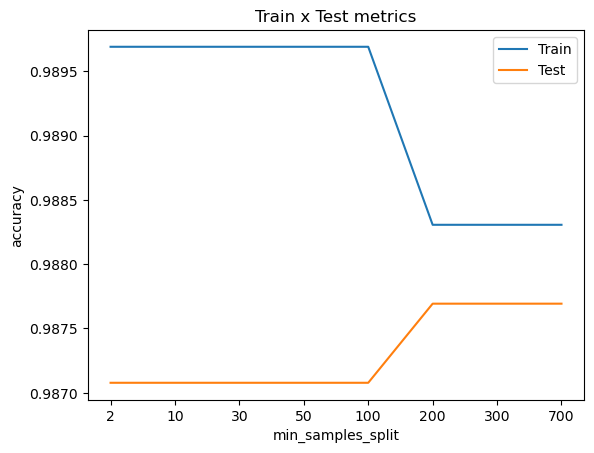

In [22]:
# Min sample split
accuracy_list_train = []
accuracy_list_test = []

for m in min_samples_split_list:
    model = DecisionTreeClassifier(min_samples_split = m, random_state = 42).fit(X_train, y_train)

    predictions_train = model.predict(X_train) ## The predicted values for the train dataset
    predictions_test = model.predict(X_test) ## The predicted values for the test dataset
    
    accuracy_train = accuracy_score(predictions_train, y_train)
    accuracy_test = accuracy_score(predictions_test, y_test)
    
    # accuracy_train, accuracy_test = predict(model)
    
    accuracy_list_train.append(accuracy_train)
    accuracy_list_test.append(accuracy_test)

plot(accuracy_list_train, accuracy_list_test, min_samples_split_list, 'min_samples_split')

Increasing the the number of min_samples_split decreases the overfit. 

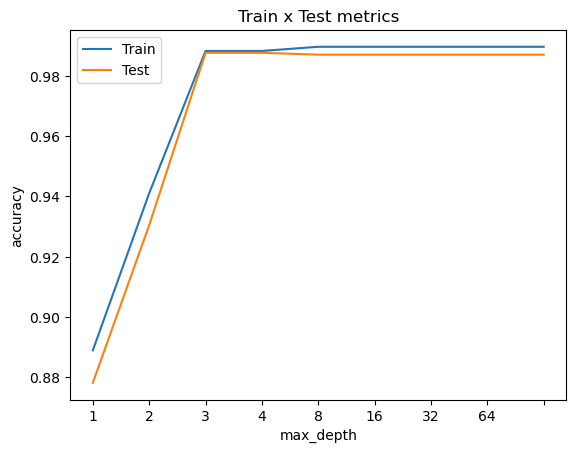

In [24]:
# Max Depth
accuracy_list_train = []
accuracy_list_test = []

for m in max_depth_list:
    
    # You can fit the model at the same time you define it, because the fit function returns the fitted estimator.
    model = DecisionTreeClassifier(max_depth = m, random_state = 42).fit(X_train,y_train) 
    
    predictions_train = model.predict(X_train) ## The predicted values for the train dataset
    predictions_test = model.predict(X_test) ## The predicted values for the test dataset
    
    accuracy_train = accuracy_score(predictions_train, y_train)
    accuracy_test = accuracy_score(predictions_test, y_test)
    
    # accuracy_train, accuracy_test = predict(model)
    
    accuracy_list_train.append(accuracy_train)
    accuracy_list_test.append(accuracy_test)


plot(accuracy_list_train, accuracy_list_test, max_depth_list, 'max_depth')

The test accuracy reaches the highest at tree_depth=8.

- `max_depth = 8`
- `min_samples_split = 200` 

In [27]:
# Final Decision tree Accuracy based on above hyperparamters
final_decision_tree_model = DecisionTreeClassifier(min_samples_split = 200, max_depth = 8, random_state = 42).fit(X_train,y_train)

predictions_train = final_decision_tree_model.predict(X_train) ## The predicted values for the train dataset
predictions_test = final_decision_tree_model.predict(X_test) ## The predicted values for the test dataset
    
accuracy_train = accuracy_score(predictions_train, y_train)
accuracy_test = accuracy_score(predictions_test, y_test)

print("Training data accuracy: ", accuracy_train)
print("Testing data accuracy: ", accuracy_test)

Training data accuracy:  0.9883058932143407
Testing data accuracy:  0.9876923076923076


### Random Forest

In [29]:
# Adding another hyperparameter called n_estimators which is how many different Decision Trees will be fitted.
n_estimators_list = [1, 5, 10, 25, 50, 100, 500]

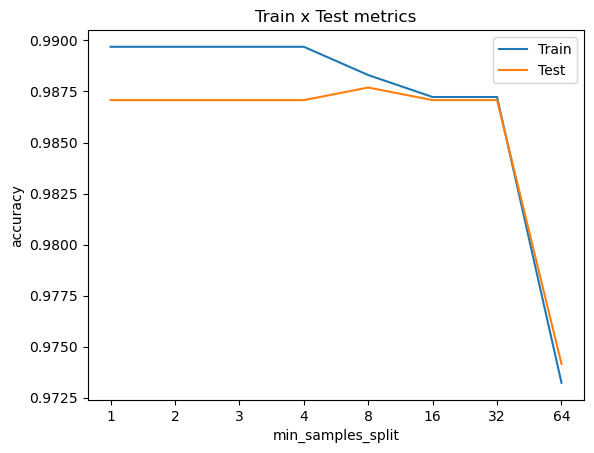

In [30]:
# Min sample split
accuracy_list_train = []
accuracy_list_test = []
for m in min_samples_split_list:
    model = RandomForestClassifier(min_samples_split = m, random_state = 42).fit(X_train,y_train) 
    
    predictions_train = model.predict(X_train) ## The predicted values for the train dataset
    predictions_test = model.predict(X_test) ## The predicted values for the test dataset
    
    accuracy_train = accuracy_score(predictions_train,y_train)
    accuracy_test = accuracy_score(predictions_test,y_test)
    
    accuracy_list_train.append(accuracy_train)
    accuracy_list_test.append(accuracy_test)

plot(accuracy_list_train, accuracy_list_test, max_depth_list, 'min_samples_split')

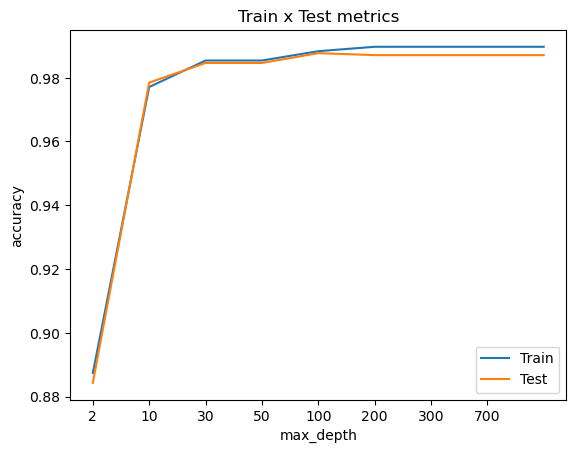

In [31]:
# Max depth
accuracy_list_train = []
accuracy_list_test = []
for m in max_depth_list:
    model = RandomForestClassifier(max_depth = m, random_state = 42).fit(X_train,y_train) 
    
    predictions_train = model.predict(X_train) ## The predicted values for the train dataset
    predictions_test = model.predict(X_test) ## The predicted values for the test dataset
    
    accuracy_train = accuracy_score(predictions_train, y_train)
    accuracy_test = accuracy_score(predictions_test, y_test)
    
    # accuracy_train, accuracy_test = predict(model)
    
    accuracy_list_train.append(accuracy_train)
    accuracy_list_test.append(accuracy_test)

plot(accuracy_list_train, accuracy_list_test, min_samples_split_list, 'max_depth')

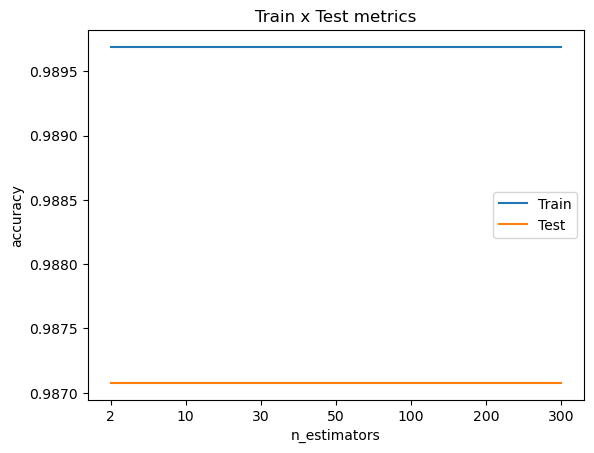

In [32]:
# n_estimators
accuracy_list_train = []
accuracy_list_test = []
for m in n_estimators_list:
    model = RandomForestClassifier(n_estimators = m, random_state = 42).fit(X_train,y_train)
    
    predictions_train = model.predict(X_train) ## The predicted values for the train dataset
    predictions_test = model.predict(X_test) ## The predicted values for the test dataset
    
    accuracy_train = accuracy_score(predictions_train,y_train)
    accuracy_test = accuracy_score(predictions_test,y_test)
    
    accuracy_list_train.append(accuracy_train)
    accuracy_list_test.append(accuracy_test)

plot(accuracy_list_train, accuracy_list_test, min_samples_split_list, 'n_estimators')

Fit a random forest with the following parameters:

 - max_depth: 8
 - min_samples_split: 100
 - n_estimators: 100 (as no change in accuracy score with increase in n_estimators)

In [34]:
# Final Random forest Accuracy based on above hyperparamters
final_random_forest_model = RandomForestClassifier(n_estimators = 100, max_depth = 100, min_samples_split = 100).fit(X_train,y_train)

predictions_train = final_random_forest_model.predict(X_train) ## The predicted values for the train dataset
predictions_test = final_random_forest_model.predict(X_test) ## The predicted values for the test dataset
    
accuracy_train = accuracy_score(predictions_train, y_train)
accuracy_test = accuracy_score(predictions_test, y_test)

print("Training data accuracy: ", accuracy_train)
print("Testing data accuracy: ", accuracy_test)

Training data accuracy:  0.9896907216494846
Testing data accuracy:  0.9870769230769231


### XGBoost

In [36]:
## Using 80% of input data to train and 20% to eval
n = int(len(X_train)*0.8)

In [37]:
X_train_fit, X_train_eval, y_train_fit, y_train_eval = X_train[:n], X_train[n:], y_train[:n], y_train[n:]
print(X_train_fit.shape)
print(X_train_eval.shape)
print(y_train_fit.shape)
print(y_train_eval.shape)

(5199, 23)
(1300, 23)
(5199,)
(1300,)


In [68]:
xgb_model = XGBClassifier(n_estimators = 500, learning_rate = 0.1, random_state = 42, early_stopping_rounds = 50, verbose = 1)
xgb_model.fit(X_train_fit,y_train_fit, eval_set = [(X_train_eval,y_train_eval)])
# Here we must pass a list to the eval_set, because you can have several different tuples ov eval sets. The parameter 
# early_stopping_rounds is the number of iterations that it will wait to check if the cost function decreased or not.
# If not, it will stop and get the iteration that returned the lowest metric on the eval set.

[0]	validation_0-logloss:0.60136
[1]	validation_0-logloss:0.52709
[2]	validation_0-logloss:0.46517
[3]	validation_0-logloss:0.41285
[4]	validation_0-logloss:0.36819
[5]	validation_0-logloss:0.32975
[6]	validation_0-logloss:0.29606
[7]	validation_0-logloss:0.26661
[8]	validation_0-logloss:0.24099
[9]	validation_0-logloss:0.21838
[10]	validation_0-logloss:0.19866
[11]	validation_0-logloss:0.18114
[12]	validation_0-logloss:0.16553
[13]	validation_0-logloss:0.15180
[14]	validation_0-logloss:0.13956
[15]	validation_0-logloss:0.12858
[16]	validation_0-logloss:0.11890
[17]	validation_0-logloss:0.11017
[18]	validation_0-logloss:0.10239
[19]	validation_0-logloss:0.09554
[20]	validation_0-logloss:0.08943
[21]	validation_0-logloss:0.08390
[22]	validation_0-logloss:0.07891
[23]	validation_0-logloss:0.07441
[24]	validation_0-logloss:0.07044
[25]	validation_0-logloss:0.06687
[26]	validation_0-logloss:0.06360
[27]	validation_0-logloss:0.06073
[28]	validation_0-logloss:0.05809
[29]	validation_0-loglos

/Users/samiksha/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [14:41:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[95]	validation_0-logloss:0.03470
[96]	validation_0-logloss:0.03468
[97]	validation_0-logloss:0.03467
[98]	validation_0-logloss:0.03466
[99]	validation_0-logloss:0.03465
[100]	validation_0-logloss:0.03464
[101]	validation_0-logloss:0.03463
[102]	validation_0-logloss:0.03462
[103]	validation_0-logloss:0.03461
[104]	validation_0-logloss:0.03460
[105]	validation_0-logloss:0.03459
[106]	validation_0-logloss:0.03458
[107]	validation_0-logloss:0.03457
[108]	validation_0-logloss:0.03456
[109]	validation_0-logloss:0.03455
[110]	validation_0-logloss:0.03455
[111]	validation_0-logloss:0.03454
[112]	validation_0-logloss:0.03454
[113]	validation_0-logloss:0.03453
[114]	validation_0-logloss:0.03453
[115]	validation_0-logloss:0.03453
[116]	validation_0-logloss:0.03452
[117]	validation_0-logloss:0.03452
[118]	validation_0-logloss:0.03451
[119]	validation_0-logloss:0.03451
[120]	validation_0-logloss:0.03451
[121]	validation_0-logloss:0.03450
[122]	validation_0-logloss:0.03451
[123]	validation_0-loglos

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=50,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [70]:
xgb_model.best_iteration

387

In [72]:
predictions_train = xgb_model.predict(X_train) ## The predicted values for the train dataset
predictions_test = xgb_model.predict(X_test) ## The predicted values for the test dataset
    
accuracy_train = accuracy_score(predictions_train, y_train)
accuracy_test = accuracy_score(predictions_test, y_test)

print("Training data accuracy: ", accuracy_train)
print("Testing data accuracy: ", accuracy_test)

Training data accuracy:  0.9896907216494846
Testing data accuracy:  0.9870769230769231
